In [64]:
from finrl.agents.stablebaselines3.models import DRLAgent
import matplotlib.pyplot as plt
import os
import pandas as pd
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS
from rl_trading_metrics import compute_metrics, summarize_all
# Ensure results folder exists
import os
os.makedirs("results", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [65]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

symbols = ['JNJ', 'AAPL', 'TSLA']
TRAIN_START_DATE = '2011-01-01'
TRAIN_END_DATE = '2020-01-01'
TRADE_START_DATE = '2020-01-01'
TRADE_END_DATE = '2022-12-31'

all_data = {}
for symbol in symbols:
    print(f"Fetching data for {symbol}")
    df = YahooDownloader(
        start_date=TRAIN_START_DATE,
        end_date=TRADE_END_DATE,
        ticker_list=[symbol]
    ).fetch_data()
    all_data[symbol] = df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for JNJ
Shape of DataFrame:  (3020, 8)
Fetching data for AAPL



[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3020, 8)
Fetching data for TSLA
Shape of DataFrame:  (3020, 8)


In [66]:
import pandas as pd

def add_cov_and_returns(df, lookback=252):
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)
    df.index = df.date.factorize()[0]  # numerical index

    cov_list = []
    return_list = []

    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i - lookback:i]
        price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
        return_lookback = price_lookback.pct_change().dropna()
        return_list.append(return_lookback)
        covs = return_lookback.cov().values
        cov_list.append(covs)

    df_cov = pd.DataFrame({
        'date': df.date.unique()[lookback:],
        'cov_list': cov_list,
        'return_list': return_list
    })

    df = df.merge(df_cov, on='date', how='left')
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)
    return df

In [67]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split

fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False
)

for symbol in symbols:
    df = all_data[symbol]
    df = fe.preprocess_data(df)
    df = add_cov_and_returns(df)
    df = df.fillna(0)  # Fill missing values if needed

    train_df = data_split(df, TRAIN_START_DATE, TRAIN_END_DATE)
    test_df = data_split(df, TRADE_START_DATE, TRADE_END_DATE)

    all_data[symbol] = {"train": train_df, "test": test_df}


Successfully added technical indicators
Successfully added technical indicators
Successfully added technical indicators


In [68]:
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS

def get_env(df):
    stock_dim = 1
    state_space = 1 + 2 * stock_dim + len(INDICATORS) * stock_dim
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 1_000_000,
        "num_stock_shares": [0],
        "buy_cost_pct": [0.001],
        "sell_cost_pct": [0.001],
        "state_space": state_space,
        "stock_dim": stock_dim,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dim,
        "reward_scaling": 1e-4
    }
    return StockTradingEnv(df=df, **env_kwargs)


In [69]:
from finrl.agents.stablebaselines3.models import DRLAgent

def train_agents(train_df, symbol):
    env_train = get_env(train_df)
    env_train, _ = env_train.get_sb_env()
    agent = DRLAgent(env=env_train)

    models = {}
    for algo in ["ppo", "a2c"]:
        print(f"🤖 Training {algo.upper()}...")
        model = agent.get_model(model_name=algo)
        trained_model = agent.train_model(model=model, tb_log_name=f"{algo}_{symbol}_log", total_timesteps=30000)
        trained_model.save(f"saved_models/{symbol}_{algo}")
        models[algo] = trained_model
    return models


In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
# Function to evaluate and plot separately

def evaluate_and_plot(models, test_df_dict, algo_name):
    plt.figure(figsize=(15, 6))
    all_results = {}

    for symbol, model in models.items():
        test_env = get_env(test_df_dict[symbol])
        df_account_value, _ = DRLAgent.DRL_prediction(model=model, environment=test_env)
        df_account_value.set_index('date', inplace=True)
        df_account_value.index = pd.to_datetime(df_account_value.index)
        all_results[f"{symbol}_{algo_name}"] = df_account_value
        plt.plot(df_account_value['account_value'], label=f"{symbol}")

    plt.title(f"{algo_name.upper()} - Account Value Comparison")
    plt.xlabel("Date")
    plt.ylabel("Account Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results/{algo_name}_comparison.png")
    plt.show()

    return all_results



📊 Training on stock: JNJ
🤖 Training PPO...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
------------------------------------
| time/              |             |
|    fps             | 1569        |
|    iterations      | 1           |
|    time_elapsed    | 1           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.098916866 |
------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1284          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00079486205 |
|    clip_fraction        | 0.00264       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.43         |
|    explained_variance   | -0.000135     |

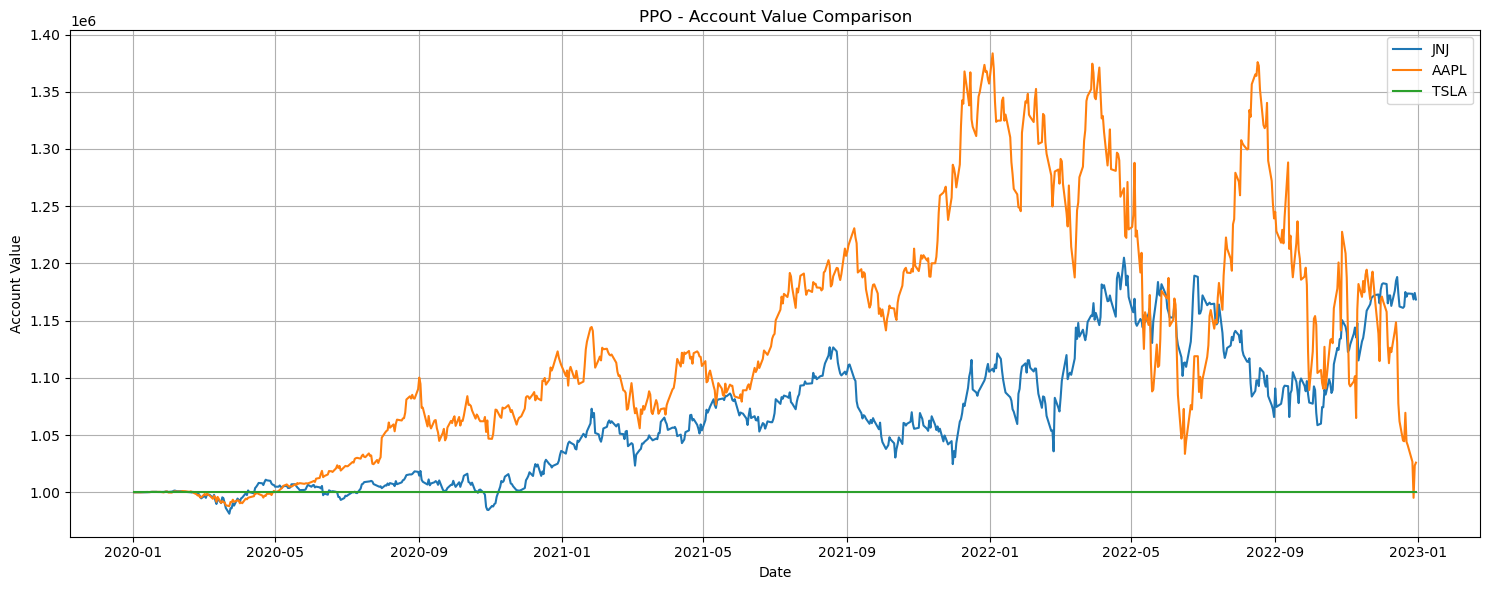

hit end!
hit end!
hit end!


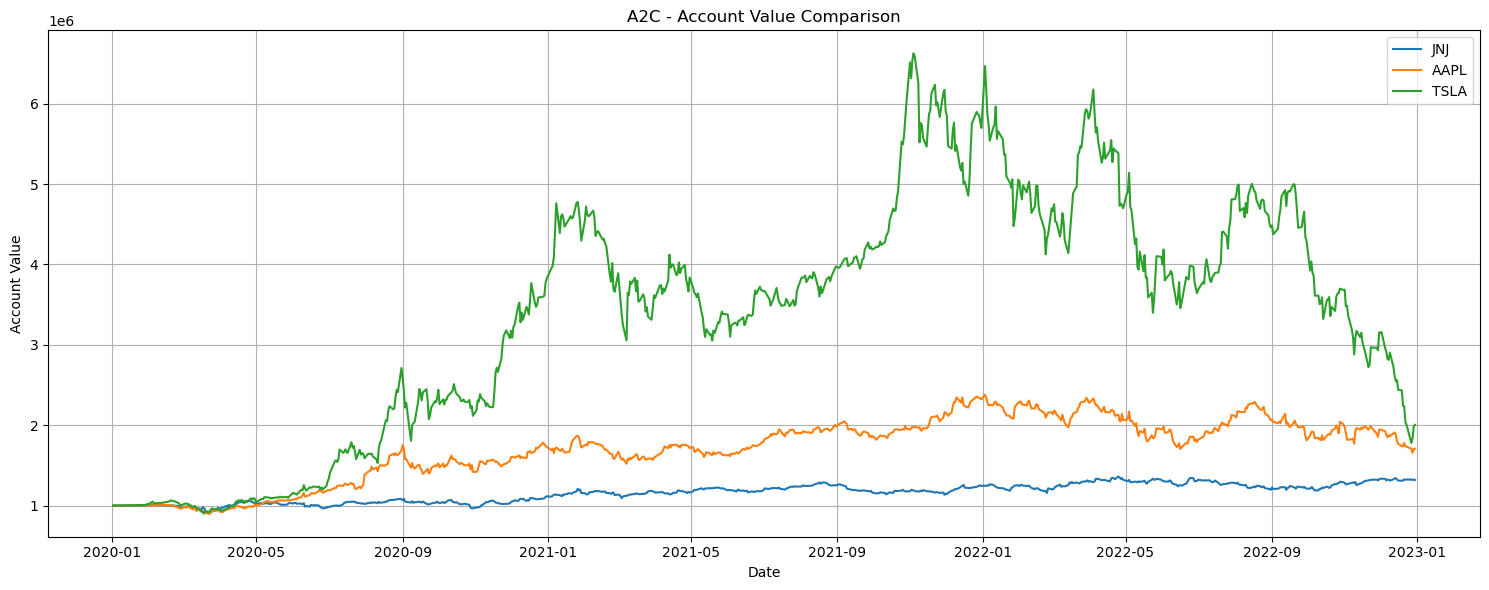

   strategy   final_value  cumulative_return  annualized_return  volatility  \
4  AAPL_a2c  1.707679e+06           0.707679           0.227004    0.311396   
5  TSLA_a2c  2.005305e+06           1.005305           0.410036    0.596130   
3   JNJ_a2c  1.318145e+06           0.318145           0.105774    0.164814   
0   JNJ_ppo  1.168479e+06           0.168479           0.058091    0.110767   
1  AAPL_ppo  1.025883e+06           0.025883           0.030848    0.211609   
2  TSLA_ppo  1.000000e+06           0.000000           0.000000    0.000000   

   sharpe_ratio  sortino_ratio  max_drawdown  
4      0.728988       1.092840     -0.303635  
5      0.687829       0.983959     -0.731495  
3      0.641776       0.968949     -0.127394  
0      0.524442       0.746740     -0.121431  
1      0.145779       0.188347     -0.280718  
2      0.000000            NaN      0.000000  


In [71]:
from stable_baselines3 import PPO, A2C

import os

def load_saved_models(symbols, algos=["ppo", "a2c"], path="saved_models"):
    models = {algo: {} for algo in algos}
    for algo in algos:
        for symbol in symbols:
            model_path = f"{path}/{symbol}_{algo}.zip"
            if os.path.exists(model_path):
                if algo == "ppo":
                    models[algo][symbol] = PPO.load(model_path)
                elif algo == "a2c":
                    models[algo][symbol] = A2C.load(model_path)
            else:
                print(f"⚠️ Model not found: {model_path}")
    return models


# trained_models = load_saved_models(symbols)


trained_models = {"ppo": {}, "a2c": {}}
test_data = {}

for symbol in symbols:
    print(f"📊 Training on stock: {symbol}")
    models = train_agents(all_data[symbol]["train"], symbol)
    trained_models["ppo"][symbol] = models["ppo"]
    trained_models["a2c"][symbol] = models["a2c"]
    test_data[symbol] = all_data[symbol]["test"]

# Step 3: Evaluate and get account values
ppo_results = evaluate_and_plot(trained_models["ppo"], test_data, "ppo")
a2c_results = evaluate_and_plot(trained_models["a2c"], test_data, "a2c")

# Step 4: Combine and summarize metrics
all_results = {**ppo_results, **a2c_results}
summary_df = summarize_all(all_results)

# Print and save summary
print(summary_df)
summary_df.to_csv("results/model_metrics_summary.csv", index=False)
